# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 12)
pd.set_option('display.width', 300)
df = pd.read_csv("ds_salaries.csv")
df.head()
print(df.dtypes)

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [2]:
from sklearn.model_selection import train_test_split

y = df['salary_in_usd']
X = df.drop(columns=['salary_in_usd', 'salary'])
# удаляю salary вместе с целевой, потому что это по факту одна и та же переменная, в зависимости от валюты, если не удалить - это будет единственный важный признак (с валютами, конечно) и наша модель будет бесполезной, потому что переводить валюты мы и в калькуляторе умеем

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1,
                                                              random_state=52)  # full_train - 0.9, test - 0.1
# 0.1 / 0.9 = 1/9 = 0.(1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.111111111,
                                                  random_state=52)  # train - 0.8, val - 0.1

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

numeric_features = X_train.select_dtypes(include=["int64"]).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_cat = enc.fit_transform(X_train[categorical_features])
X_val_cat = enc.transform(X_val[categorical_features])
X_test_cat = enc.transform(X_test[categorical_features])

X_train_num = X_train[numeric_features].to_numpy()
X_val_num = X_val[numeric_features].to_numpy()
X_test_num = X_test[numeric_features].to_numpy()

X_train_encoded = np.hstack([X_train_cat, X_train_num])
X_val_encoded = np.hstack([X_val_cat, X_val_num])
X_test_encoded = np.hstack([X_test_cat, X_test_num])

linreg = LinearRegression()
linreg.fit(X_train_encoded, y_train)

y_val_predicted = linreg.predict(X_val_encoded)

print('MAPE: ', mean_absolute_percentage_error(y_val, y_val_predicted))
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_val_predicted)))

MAPE:  0.3308699666064591
RMSE:  44494.04669529134


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [4]:
from xgboost.sklearn import XGBRegressor

params = {
    'max_depth': [3, 5, 7, 10],  # максимальная глубина дерева
    'learning_rate': [0.01, 0.05, 0.1, 0.3],  # eta
    'n_estimators': [100, 200, 300, 500],  # количество деревьев
    'gamma': [0, 0.1, 0.5, 1.0],  # минимальное снижение функции потерь для разбиения
    'subsample': [0.6, 0.8, 1.0],  # доля выборки для каждого дерева
    'colsample_bytree': [0.6, 0.8, 1.0]  # доля используемых признаков для каждого дерева
}

xgb = XGBRegressor(random_state=52)

In [5]:
from sklearn.model_selection import RandomizedSearchCV
import time

# Для подбора гиперпараметров из такой огромной сетки разумно использовать randsearchcv
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=params,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=52,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train_encoded, y_train)
train_time = time.time() - start_time

best_model = random_search.best_estimator_
print("Лучшие гиперпараметры:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\sit

Лучшие гиперпараметры: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [6]:
start_time = time.time()
y_val_predicted = best_model.predict(X_val_encoded)
predict_time = time.time() - start_time

print('MAPE: ', mean_absolute_percentage_error(y_val, y_val_predicted))
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_val_predicted)))
print('Training time:', train_time)
print('Predict time:', predict_time)

MAPE:  0.3205549716949463
RMSE:  42816.6053768862
Training time: 13.550081253051758
Predict time: 0.0026454925537109375


Как мы видим, наше качество модели слегка увеличилось, но недостаточно для того, чтобы мы останавливались.

## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [7]:
from catboost import CatBoostRegressor

params = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'iterations': [100, 200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

catboost = CatBoostRegressor(verbose=0, random_state=52)

In [8]:
random_search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=params,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=52,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train_encoded, y_train)
train_time = time.time() - start_time

best_model = random_search.best_estimator_
print("Лучшие гиперпараметры:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие гиперпараметры: {'subsample': 1.0, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 6}


In [9]:
start_time = time.time()
y_val_predicted = best_model.predict(X_val_encoded)
predict_time = time.time() - start_time

print('MAPE: ', mean_absolute_percentage_error(y_val, y_val_predicted))
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_val_predicted)))
print('Training time:', train_time)
print('Predict time:', predict_time)

MAPE:  0.3146968257924399
RMSE:  42801.886596317905
Training time: 35.45347809791565
Predict time: 0.01702284812927246


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [10]:
from catboost import Pool

train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features.tolist())
val_pool = Pool(data=X_val, label=y_val, cat_features=categorical_features.tolist())

params = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'iterations': [100, 200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

catboost = CatBoostRegressor(verbose=0, random_state=52)

In [11]:
random_search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=params,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=52,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train, y_train,
                  cat_features=categorical_features.tolist())  # используем некодированные датасеты, потому что catboost сам их обрабатывает
train_time = time.time() - start_time

best_model = random_search.best_estimator_
print("Лучшие гиперпараметры:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие гиперпараметры: {'subsample': 0.8, 'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 6}


In [12]:
start_time = time.time()
y_val_predicted = best_model.predict(X_val)
predict_time = time.time() - start_time

print('MAPE: ', mean_absolute_percentage_error(y_val, y_val_predicted))
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_val_predicted)))
print('Training time:', train_time)
print('Predict time:', predict_time)

MAPE:  0.3376371170395717
RMSE:  43202.165723559854
Training time: 258.52606439590454
Predict time: 0.002833127975463867


**Ответ:** На удивление, у меня catboost с pool показал себя сильно хуже, чем обычный catboost с encoded датасетом. Метрики ошибок выросли (MAPE на 2%, RMSE на 500), а время стало аномально большим. Вероятно, время обучения такое огромное из-за большого количества деревьев (100-500) и маленького learning rate. Результат стал хуже, скорее всего, из-за большего смещения на увеличение количества деревьев, отсюда увеличение коэффициента регуляризации для баланса и предотвращения переобучения с таким количеством деревьев и маленький lr, модель стала чуть более сложной - с колебаниями, которые оказались лишние, похоже на небольшое переобучение.

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [13]:
from lightgbm import LGBMRegressor

params = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 200, 300, 500],
    'num_leaves': [15, 31, 63, 127],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgbm = LGBMRegressor(random_state=52, verbose=-1)

In [14]:
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=params,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=52,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train_encoded, y_train)
train_time = time.time() - start_time

best_model = random_search.best_estimator_
print("Лучшие гиперпараметры:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие гиперпараметры: {'subsample': 0.6, 'num_leaves': 15, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [15]:
start_time = time.time()
y_val_predicted = best_model.predict(X_val_encoded)
predict_time = time.time() - start_time

print('MAPE: ', mean_absolute_percentage_error(y_val, y_val_predicted))
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_val_predicted)))
print('Training time:', train_time)
print('Predict time:', predict_time)

MAPE:  0.3280455211120822
RMSE:  43398.98154472531
Training time: 26.999305248260498
Predict time: 0.006770610809326172


C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

In [16]:
results_table = np.array([["Модель", "MAPE", "RMSE", "Training time", "Predict time"],
                          ["LinearRegression", "0.331", "44.494", "-", "-"],
                          ["XGBRegressor", "0.313", "42.695", "9.57", "0.002"],
                          ["CatBoost (encoded)", "0.315", "42.802", "39.08", "0.022"],
                          ["CatBoost (non-encoded, Pool)", "0.338", "43.202", "237.66", "0.002"],
                          ["LGBMRegressor", "0.328", "43.399", "19.81", "0.0025"]])
results_table

array([['Модель', 'MAPE', 'RMSE', 'Training time', 'Predict time'],
       ['LinearRegression', '0.331', '44.494', '-', '-'],
       ['XGBRegressor', '0.313', '42.695', '9.57', '0.002'],
       ['CatBoost (encoded)', '0.315', '42.802', '39.08', '0.022'],
       ['CatBoost (non-encoded, Pool)', '0.338', '43.202', '237.66',
        '0.002'],
       ['LGBMRegressor', '0.328', '43.399', '19.81', '0.0025']],
      dtype='<U28')

**Ответ:** 
В интересах удобства я сделал целую таблицу с результатами. По ней чётко видно следующее: лидер по всем параметрам сразу - XGBoost. Худшие результаты распределены по разным моделям: худший MAPE у Pool CatBoost, RMSE - LinReg, TrainingTime - Pool CatBoost, Predict time - CatBoost. Однако самая удобная оказалась CatBoost Pool модель, потому что она использует свои встроенные алгоритмы кодирования категориальных данных, поэтому умеет работать без предобработки.

Подбор гиперпараметров по всем моделям следующий:
XGboost: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}
CatBoost: {'subsample': 1.0, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 6}
CatBoost+Pool: {'subsample': 0.8, 'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 6}
LightGBM: {'subsample': 0.6, 'num_leaves': 15, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

Заметно, что почти везде количество деревьев - 200-300, но на CatBoost+Pool - 500, что может указывать на переобучение, большую регуляризацию для баланса и маленький lr. Max depth везде 3 или 6, что довольно очевидно (у нас не "пни" и не "секвойи" на 50 ветвлений, обычные небольшие решающие деревья для бустинга). Интересно, что subsample у lgbm довольно маленький - 60% выборки, в остальном параметры уникальные для каждой модели.

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [17]:
import pandas as pd

ratings_og = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true",
                        engine='openpyxl')
ratings_og.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,...,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,...,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [18]:
ratings = ratings_og.transpose()
ratings

,0,1,2,3,4,5,...,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,...,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,...,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,...,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,...,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [19]:
ratings = ratings.drop('user', axis=0)

In [20]:
ratings

,0,1,2,3,4,5,...,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,...,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,...,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,...,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [21]:
ratings.fillna(0, inplace=True)

ratings.sample()

,0,1,2,3,4,5,...,4994,4995,4996,4997,4998,4999
sublime,0.0,0.0,0.027718,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [22]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5, random_state=42)
km.fit(ratings)

KMeans(n_clusters=5, random_state=42)

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [23]:
counts = pd.Series(km.labels_).groupby(km.labels_).size()
print(counts)

0    115
1      1
2      1
3    882
4      1
dtype: int64


**Ответ:** Видимо, классы расположены довольно плотно друг к другу (абсолютными значениями), поэтому они слиплись в основную массу под меткой 3, также произошло с меткой 0, а остальные исполнителей в качестве выбросов определились в отдельные классы.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [24]:
artists_clusters = pd.DataFrame({'artist': ratings.index, 'cluster': km.labels_})
single_cluster_artists = artists_clusters[artists_clusters['cluster'].isin([1, 2, 4])]
print(single_cluster_artists[['artist', 'cluster']])

           artist  cluster
0     the beatles        4
10            niИ        2
931  日dir en grey        1


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [25]:
listen_counts = (ratings > 0).sum(axis=1)  # Количество ненулевых значений по строкам
total_users = ratings.shape[1]
user_fraction = listen_counts / total_users

mean_listen_share = ratings[ratings > 0].mean(axis=1)

analysis = pd.DataFrame({
    'user_share': user_fraction,
    'mean_listen_share': mean_listen_share
}) 

print(analysis.loc[['the beatles', 'niИ', '日dir en grey']].sort_values(by='user_share', ascending=False))

              user_share  mean_listen_share
the beatles       0.3342           0.054964
niИ               0.1182           0.054740
日dir en grey      0.0102           0.165582


**Ответ:** Получили, что the_beatles слушала треть всех пользователей, но в среднем из тех, кто слушали, их слушали не так интенсивно, что делает такую комбинацию свойств уникальной. niИ слушали 0.11 всех пользователей, но, как и в случае с the beatles, не так интенсивно. В случае с третьим исполнителем всё наоборот - слушают мало людей, но кто слушает - делает это интенсивно. 

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [26]:
from sklearn.preprocessing import normalize

ratings_normalized = normalize(ratings, norm='l2', axis=1)
ratings_normalized = pd.DataFrame(ratings_normalized, index=ratings.index, columns=ratings.columns)
ratings_normalized

,0,1,2,3,4,5,...,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,...,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,...,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000
群星,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000
agalloch,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000
meshuggah,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [27]:
km = KMeans(n_clusters=5, random_state=42)
km.fit(ratings_normalized)

counts = pd.Series(km.labels_).groupby(km.labels_).size()
print("Размеры кластеров:")
print(counts)

Размеры кластеров:
0     79
1    162
2    133
3    140
4    486
dtype: int64


**Ответ** # Стало намного лучше, теперь кластеризация ищет адекватные размеры кластеров, ее можно назвать полезной

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [28]:
from scipy.spatial.distance import cosine

centroids = km.cluster_centers_
artists_clusters = pd.DataFrame({'artist': ratings_normalized.index, 'cluster': km.labels_})
artists_clusters

,artist,cluster
0,the beatles,3
1,radiohead,4
2,deathcab for cutie,1
3,coldplay,1
4,modest mouse,4
...,...,...
995,michal w. smith,1
996,群星,4
997,agalloch,4
998,meshuggah,4


In [29]:
top_10 = []
for index_cluster in range(centroids.shape[0]):
    artists_in_current_cluster = artists_clusters[artists_clusters["cluster"] == index_cluster]["artist"]
    artists_cosine_length = pd.DataFrame(
        {
            'artist': artists_in_current_cluster,
            'length_to_center': artists_in_current_cluster.apply(
                lambda artist: cosine(centroids[index_cluster], ratings_normalized.loc[artist].values)
            )
        }
    )
    sorted_artists_cosine_length = artists_cosine_length.sort_values(axis=0, by='length_to_center')
    top_10.append(sorted_artists_cosine_length.head(10))
for i in top_10:
    print(i)
    print()

                           artist  length_to_center
128                           nas          0.463886
75                          jay-z          0.495511
9                      kanye west          0.520057
133              lupe the gorilla          0.583878
137          a tribe called quest          0.586652
153  the roots featuring d'angelo          0.593835
463                     gangstarr          0.627951
806                little brother          0.629114
73                     lil' wayne          0.632561
802           murs and 9th wonder          0.635230

                        artist  length_to_center
42                fall out boy          0.634882
182  the all-americian rejects          0.655979
80                    paramore          0.658733
246             kelly clarkson          0.664350
58                  john mayer          0.674993
198                   the fray          0.675170
112                    maroon5          0.688339
117    dashboard confesssional     

**Ответ:** Как мы видим, смысл у кластеров точно есть, по крайней мере я его увидел. 
В классе "0" собран классический американский реп, который стал известен во всем мире. 
Класс "1" - поп-рок и поп-панк, фанк-рок, хард-рок.
Класс "2" - панк-рок, инди-рок, поп-панк.
Класс "3" - я бы сказал, саммый классический рок в своём истинном обличии, а также группы, которые его продвинули в массы. Рок-н-ролл, рок, альтернативный рок.
Класс "4" - альтернативный рок, инди рок, арт-рок.

В общем, только один класс чётко отделён от остальных, а 1-4 классы собрали в себя разные виды рока, но всё еще смогли поделиться. Я бы объединил 2 и 4 классы, тогда разбиение будет более чёткое.


## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

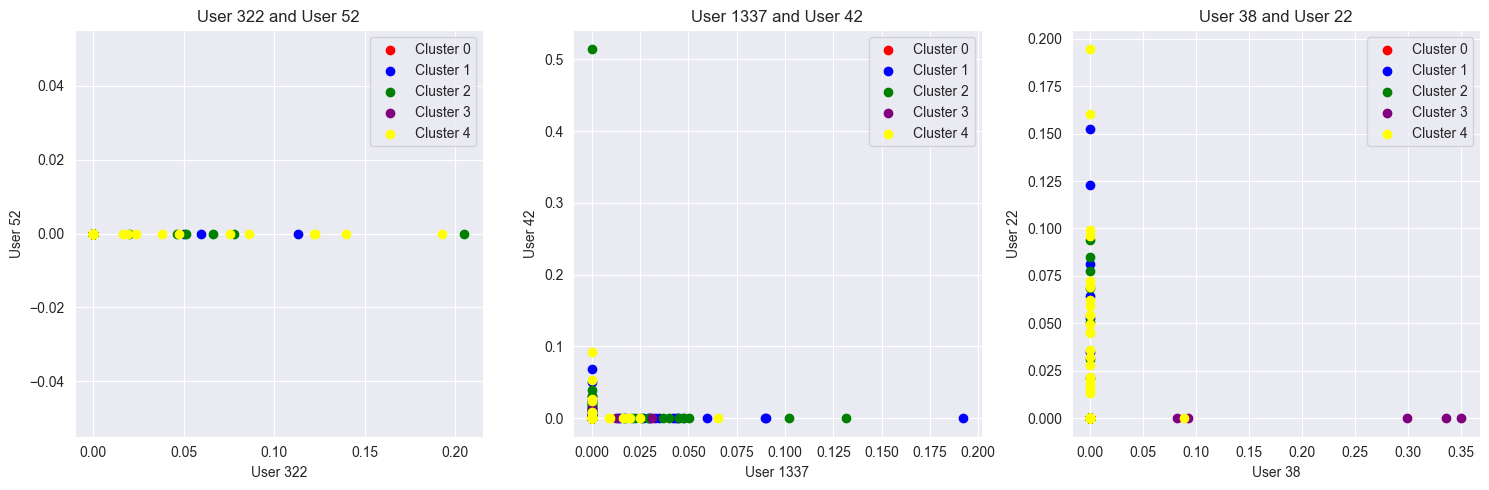

In [30]:
import matplotlib.pyplot as plt

user_pairs = [
    (322, 52),
    (1337, 42),
    (38, 22)
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = ['red', 'blue', 'green', 'purple', 'yellow']

for i in range(len(user_pairs)):
    x = ratings_normalized.iloc[:, user_pairs[i][0]]
    y = ratings_normalized.iloc[:, user_pairs[i][1]]
    for cluster in range(5):
        mask = km.labels_ == cluster
        axes[i].scatter(x[mask], y[mask], c=colors[cluster], label=f'Cluster {cluster}')
    axes[i].set_xlabel(f'User {user_pairs[i][0]}')
    axes[i].set_ylabel(f'User {user_pairs[i][1]}')
    axes[i].set_title(f'User {user_pairs[i][0]} and User {user_pairs[i][1]}')
    axes[i].legend()

plt.tight_layout()
plt.show()

**Ответ:** 
Почему визуализации получились такими? 
- Потому что мы рассматриваем всего лишь двух случайных людей, у которых слишком мало совпадений музыкальных вкусов. Первый график выродился в точки на оси ох, потому что 52 пользователь ничего не слушал (вообще ничего... Я проверил по исходным данным, это правда), значит все его значения - 0, остальные - доли прослушивания 322 пользователя. Второй и третий - похожи, потому что являются типичным представлением наших графиков. Из-за малого шанса совпадения вкусов (чтобы один и второй пользователь слушали одного исполнителя), мы получаем картину, где данные раскидались по осям. Однако, даже так можно увидеть кластеризацию: на 3-ем графике у 38 пользователя почти всегда слушались песни из 3 кластера, а у 22 пользователя - из 4, 2 и 1 кластеров. На 2-ом графике они перемешались. 

Хорошо ли они отражают разделение на кластеры? Почему? 
- Нет, потому что наша выборка свойств слишком мала (2 человека), однако это единственный способ отобразить наши данные в 2д график без потерь

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

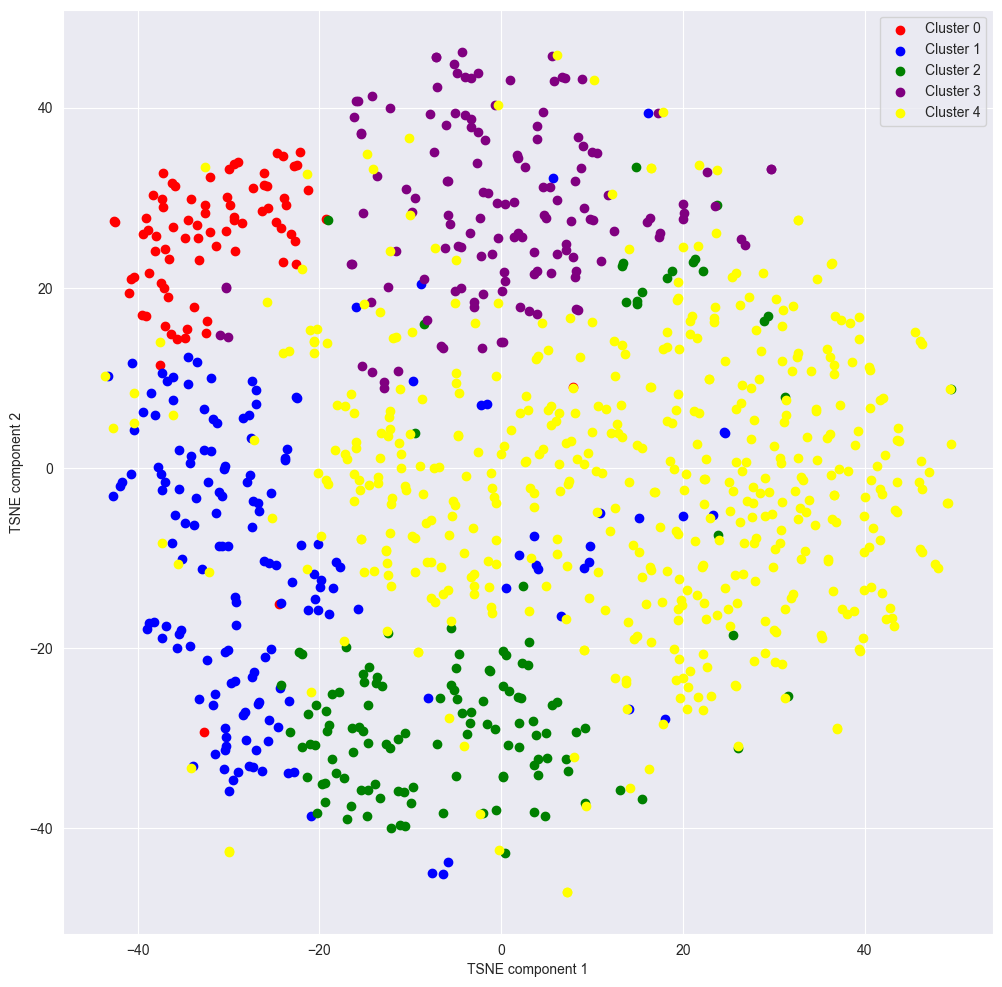

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(ratings_normalized)

plt.figure(figsize=(12, 12))
for cluster in range(5):
    mask = km.labels_ == cluster
    plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1], c=colors[cluster], label=f'Cluster {cluster}')
plt.xlabel('TSNE component 1')
plt.ylabel('TSNE component 2')
plt.legend()
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [32]:
from sklearn.metrics import silhouette_score

silhouette_scores = {n: None for n in range(2, 101)}

print("Выполнено обучение для кластеров: ", end='')
for n_clusters in silhouette_scores.keys():
    km_cur = KMeans(n_clusters=n_clusters, random_state=42)
    km_cur.fit(ratings_normalized)
    silhouette_scores[n_clusters] = silhouette_score(ratings_normalized, km_cur.labels_)
    print(f"{n_clusters},", end='')
print()

best_n_clusters = max(silhouette_scores, key=lambda k: silhouette_scores[k])
best_score = silhouette_scores[best_n_clusters]

print(f"Лучшее количество кластеров: {best_n_clusters}, индекс силуэта = {best_score}")

Выполнено обучение для кластеров: 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,
Лучшее количество кластеров: 98, индекс силуэта = 0.013327108441541911


Выведите исполнителей, ближайших к центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [33]:
km = KMeans(n_clusters=best_n_clusters, random_state=42)
km.fit(ratings_normalized)

counts = pd.Series(km.labels_).groupby(km.labels_).size()
print("Размеры кластеров:")
print(counts)

Размеры кластеров:
0      6
1     15
2     16
3     10
4     12
      ..
93     5
94    14
95     9
96     4
97     7
Length: 98, dtype: int64


In [34]:
centroids = km.cluster_centers_
artists_clusters = pd.DataFrame({'artist': ratings_normalized.index, 'cluster': km.labels_})

top_3 = []
for index_cluster in range(centroids.shape[0]):
    artists_in_current_cluster = artists_clusters[artists_clusters["cluster"] == index_cluster]["artist"]
    artists_cosine_length = pd.DataFrame(
        {
            'artist': artists_in_current_cluster,
            'length_to_center': artists_in_current_cluster.apply(
                lambda artist: cosine(centroids[index_cluster], ratings_normalized.loc[artist].values)
            )
        }
    )
    sorted_artists_cosine_length = artists_cosine_length.sort_values(axis=0, by='length_to_center')
    top_3.append(sorted_artists_cosine_length.head(3))
for i in range(len(top_3)):
    print(f'{i} cluster: ')
    print(top_3[i])
    print()

0 cluster: 
             artist  length_to_center
374         dr. dre          0.451205
259       the faint          0.523073
630  violent femmes          0.541796

1 cluster: 
             artist  length_to_center
58       john mayer          0.470144
600  matt nathanson          0.495609
844    gavin degraw          0.562061

2 cluster: 
             artist  length_to_center
21    white stripes          0.476102
14             beck          0.607384
444  the raconteurs          0.608539

3 cluster: 
             artist  length_to_center
219          fugazi          0.463915
471      jawbreaker          0.540241
447  sleater-kinney          0.607036

4 cluster: 
                           artist  length_to_center
134                    ryan adams          0.510370
145                band of horses          0.528710
944  ryan adams and the cardinals          0.607589

5 cluster: 
         artist  length_to_center
207   dj shadow          0.452265
220        rjd2          0.563461
398  

**Ответ:** Теперь классов сильно больше, чем было, однако сейчас я не могу оценить кластеризацию так хорошо, как в начале, пробежавшись по всем классам.
Я не эксперт по року, но по американскому репу могу точно определить несколько кластеров

1. Кластер 28 - eminem, 50 cent, tupak shakur 
- Американский рэп около 2000ых годов. Интересно, что тут есть и исполнители из west и east coast вперемешку (west coast - tupac, возглавлявший west, east coast - 50 cent и нейтральный eminem) 
2. Кластер 87 - T.I., Lil Wayne, Rick Ross
- Американский рэп южного побережья, (все трое - представители данного жанра родом оттуда же) 

Помимо американского репа я заметил чёткий кластер классической музыки
3. Кластер 73 - Бах Иоганн Себастьян, Вивальди, Моцарт
- haha, classic

Сделайте t-SNE визуализацию полученной кластеризации.

In [35]:
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(ratings_normalized)

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

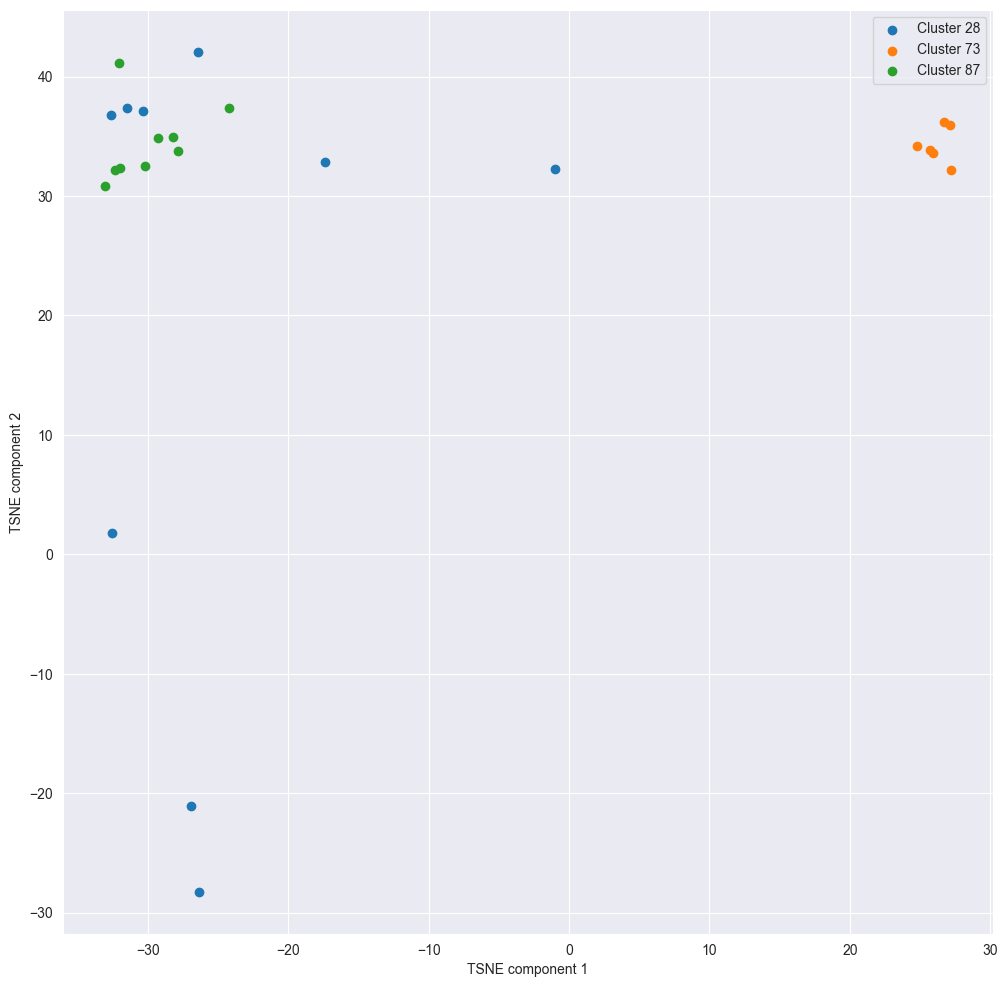

In [36]:
classes = [28, 73, 87]
plt.figure(figsize=(12, 12))
for cluster in classes:
    mask = km.labels_ == cluster
    plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1], label=f'Cluster {cluster}')
plt.xlabel('TSNE component 1')
plt.ylabel('TSNE component 2')
plt.legend()
plt.show()

**Ответ:** Как я и описал выше, 28 кластер разрозненный и широкий, а также немного похож на 87 (тоже американский реп). Разность людей в нём по "бандам" в 90-ых дала эту разрозненность в том числе, я ее предсказал. Другие классы чётко скопились в одни места, причем 73 - дальше всех, что похоже на правду